In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

cd Donor_Naive_bAYES

/Users/hiralparmar/Downloads/Donor_Naive_bAYES


In [3]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [6]:
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


# Univariate analysis for featureteacher_number_of_previously_posted_projects

In [7]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [8]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

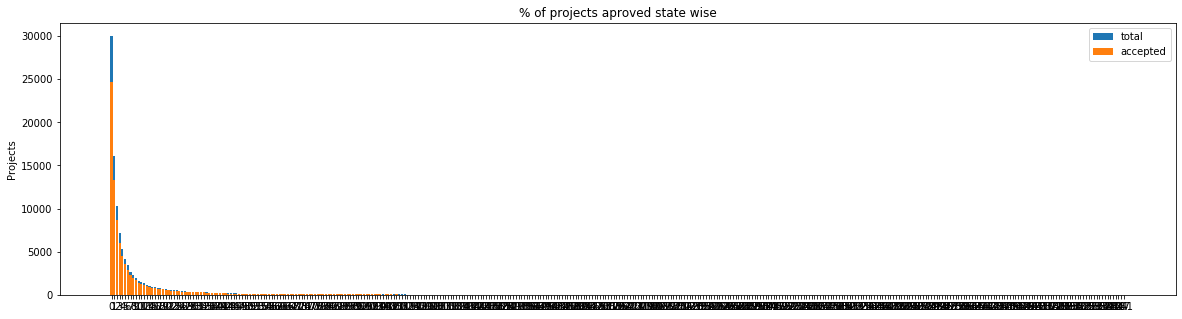

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
     teacher_number_of_previously_posted_projects  project_is_approved  total  \
242                                           242                    1      1   
268                                           270                    1      1   
234                                           234                    1      1   
335                                           347                    1      1   
373                                 

In [9]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved' , top=False)

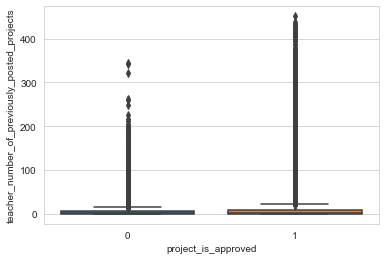

In [10]:
sns.set_style("whitegrid") 
sns.boxplot(x = 'project_is_approved', y = 'teacher_number_of_previously_posted_projects', data = project_data) 



we find more number of projected previsouly posted in project approved

# Univariate analysis for feature resource summary

In [11]:
sub_catogories = list(project_data['project_resource_summary'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [12]:
project_data['project_resource_summary'] = sub_cat_list

project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,Mystudentsneedopportunitiestopracticebeginning...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,Mystudentsneedaprojectortohelpwithviewingeduca...,7,1


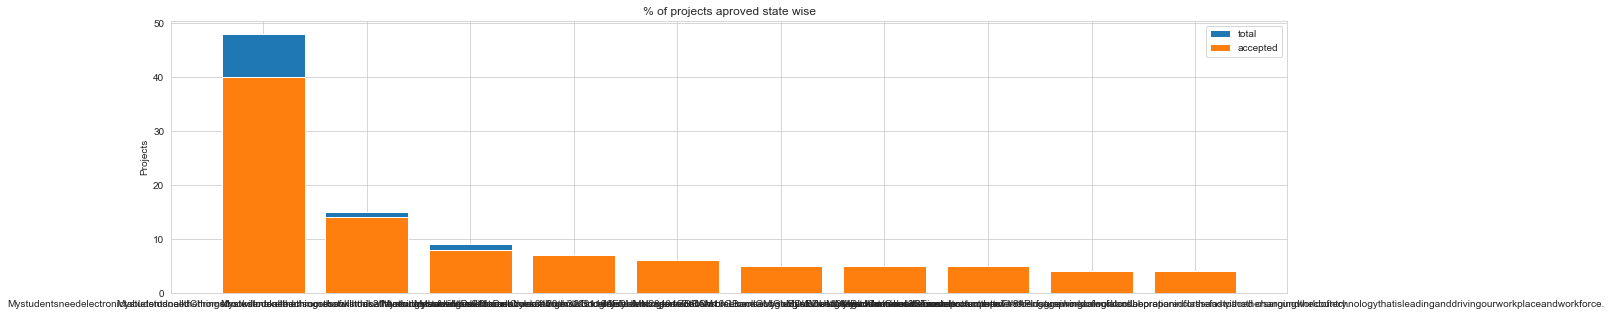

                                project_resource_summary  project_is_approved  \
56503  Mystudentsneedelectronictabletstodoallthething...                   40   
10221  MystudentsneedChromebookstodoallthethingsthatw...                   14   
51318  Mystudentsneedchromebookstodoallthethingsthatw...                    8   
18711  MystudentsneedaDellChromebook3120andaGoogleEDU...                    7   
18707  MystudentsneedaDellChromebook3120116CeleronN28...                    6   

       total       Avg  
56503     48  0.833333  
10221     15  0.933333  
51318      9  0.888889  
18711      7  1.000000  
18707      6  1.000000  
                                project_resource_summary  project_is_approved  \
18713  MystudentsneedaDellChromebookandGoogleEDUManag...                    5   
4340   Mystudentsneed3\"iPad\"minisandcasestoprotectt...                    5   
4327   Mystudentsneed3TexasInstrumentsTI-84Plusgraphi...                    5   
3863   Mystudentsneed3Chromebookcompute

In [13]:
univariate_barplots(project_data, 'project_resource_summary', 'project_is_approved', top=10)

In [14]:
project_data = pd.read_csv('train_data.csv')


In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os

In [16]:

# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

In [17]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
#project_data['project_subject_categories'].value_counts()

In [18]:
project_data['teacher_prefix'].value_counts()
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


In [19]:
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
#project_data['teacher_prefix'].value_counts()

In [20]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
#project_data['teacher_prefix'].value_counts()

In [21]:
project_data['project_subject_subcategories'].value_counts()

Literacy                                    9486
Literacy, Mathematics                       8325
Literature & Writing, Mathematics           5923
Literacy, Literature & Writing              5571
Mathematics                                 5379
                                            ... 
Economics, Nutrition Education                 1
Economics, Music                               1
Gym & Fitness, Parent Involvement              1
Civics & Government, Nutrition Education       1
Community Service, Gym & Fitness               1
Name: project_subject_subcategories, Length: 401, dtype: int64

In [22]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                                 9486
literacy_mathematics                     8325
literature_writing_mathematics           5923
literacy_literature_writing              5571
mathematics                              5379
                                         ... 
gym_fitness_warmth_care_hunger              1
gym_fitness_parentinvolvement               1
extracurricular_financialliteracy           1
economics_foreignlanguages                  1
college_careerprep_warmth_care_hunger       1
Name: project_subject_subcategories, Length: 401, dtype: int64

In [23]:
project_data['school_state'].value_counts()

CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3936
MI     3161
PA     3109
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: school_state, dtype: int64

In [24]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

In [25]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [27]:
project_data['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

In [28]:
print("printing some random reviews")
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

printing some random reviews
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [29]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [30]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|██████████| 109248/109248 [00:03<00:00, 27661.83it/s]


In [31]:
print("printing some random reviews")
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

printing some random reviews
9 love reading pure pleasure
34 ball
147 needs chromebook


In [32]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [33]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [34]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|██████████| 109248/109248 [01:34<00:00, 1153.38it/s]


In [35]:
project_data['preprocessed_essays'] = preprocessed_essays

In [36]:
project_data['preprocessed_titles']=preprocessed_titles

In [37]:
project_data.drop(['project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary','project_title','essay'], axis=1, inplace=True)


In [38]:
project_data.drop(['Unnamed: 0'], axis=1, inplace=True)


In [39]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [40]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [41]:
project_data['price'].head()

0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

In [42]:
project_data.drop(['quantity'], axis=1, inplace=True)

# count word in title

In [44]:
#https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/
title_word_count = []
for i in project_data["preprocessed_titles"] :
    find_length = len(i.split())
    title_word_count.append(find_length)
project_data["title_word_count"] = title_word_count


In [45]:
#count essay word length
#https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/
essay_word_count = []
for i in project_data["preprocessed_essays"] :
    find_length = len(i.split())
    essay_word_count.append(find_length)
project_data["essay_word_count"] = essay_word_count


In [46]:
project_data.drop(['project_submitted_datetime'], axis=1, inplace=True)

# train test split

In [47]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# Calculate Bag of Words

In [48]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_essay_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_essay_bow.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_essay_bow.transform(X_train['preprocessed_essays'].values)
X_cv_essay_bow = vectorizer_essay_bow.transform(X_cv['preprocessed_essays'].values)
X_test_essay_bow = vectorizer_essay_bow.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)

(49041, 13) (49041,)
(24155, 13) (24155,)
(36052, 13) (36052,)
After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


Bag of words for project_title feature

In [49]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_project_title_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_project_title_bow.fit(X_train['preprocessed_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_bow = vectorizer_project_title_bow.transform(X_train['preprocessed_titles'].values)
X_cv_project_title_bow = vectorizer_project_title_bow.transform(X_cv['preprocessed_titles'].values)
X_test_project_title_bow = vectorizer_project_title_bow.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(X_train_project_title_bow.shape, y_train.shape)
print(X_cv_project_title_bow.shape, y_cv.shape)
print(X_test_project_title_bow.shape, y_test.shape)
print("="*100)

(49041, 13) (49041,)
(24155, 13) (24155,)
(36052, 13) (36052,)
After vectorizations
(49041, 3410) (49041,)
(24155, 3410) (24155,)
(36052, 3410) (36052,)


# One hot encoding for other categorical features


for school state feature

In [50]:
vectorizer_school_state = CountVectorizer()
vectorizer_school_state.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer_school_state.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer_school_state.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer_school_state.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer_school_state.get_feature_names())
print("="*100)

After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


for teacher_prefix feature

In [51]:
vectorizer_teacher_prefix = CountVectorizer()
vectorizer_teacher_prefix.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer_teacher_prefix.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer_teacher_prefix.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_teacher_prefix.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer_teacher_prefix.get_feature_names())
print("="*100)

After vectorizations
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


for project_grade_Category feature

In [52]:
vectorizer_project_grade_category = CountVectorizer()
vectorizer_project_grade_category.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer_project_grade_category.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer_project_grade_category.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe =vectorizer_project_grade_category.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer_project_grade_category.get_feature_names())
print("="*100)

After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


for project_subject_categories and project_subject_subcategories

In [53]:
vectorizer_project_subject_category = CountVectorizer()
vectorizer_project_subject_category.fit(X_train['project_subject_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subject_ohe = vectorizer_project_subject_category.transform(X_train['project_subject_categories'].values)
X_cv_subject_ohe = vectorizer_project_subject_category.transform(X_cv['project_subject_categories'].values)
X_test_subject_ohe =vectorizer_project_subject_category.transform(X_test['project_subject_categories'].values)

print("After vectorizations")
print(X_train_subject_ohe.shape, y_train.shape)
print(X_cv_subject_ohe.shape, y_cv.shape)
print(X_test_subject_ohe.shape, y_test.shape)

print("="*100)

After vectorizations
(49041, 50) (49041,)
(24155, 50) (24155,)
(36052, 50) (36052,)


In [54]:
vectorizer_project_subject_subcategories = CountVectorizer()
vectorizer_project_subject_subcategories.fit(X_train['project_subject_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_sub_subject_ohe = vectorizer_project_subject_subcategories.transform(X_train['project_subject_subcategories'].values)
X_cv_sub_subject_ohe = vectorizer_project_subject_subcategories.transform(X_cv['project_subject_subcategories'].values)
X_test_sub_subject_ohe =vectorizer_project_subject_subcategories.transform(X_test['project_subject_subcategories'].values)

print("After vectorizations")
print(X_train_sub_subject_ohe .shape, y_train.shape)
print(X_cv_sub_subject_ohe.shape, y_cv.shape)
print(X_test_sub_subject_ohe.shape, y_test.shape)

print("="*100)

After vectorizations
(49041, 377) (49041,)
(24155, 377) (24155,)
(36052, 377) (36052,)


# encoding numerical features: Price

# price feature

In [55]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)).reshape(-1,1)
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1)).reshape(-1,1)
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1)).reshape(-1,1)



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


normalize title word count feature

In [56]:

normalizer = Normalizer()

normalizer.fit(X_train['title_word_count'].values.reshape(1,-1))

X_train_title_word_count_norm = normalizer.transform(X_train['title_word_count'].values.reshape(1,-1)).reshape(-1,1)
X_cv_title_word_count_norm = normalizer.transform(X_cv['title_word_count'].values.reshape(1,-1)).reshape(-1,1)
X_test_title_word_count_norm = normalizer.transform(X_test['title_word_count'].values.reshape(1,-1)).reshape(-1,1)



print("After vectorizations")
print(X_train_title_word_count_norm.shape, y_train.shape)
print(X_cv_title_word_count_norm.shape, y_cv.shape)
print(X_test_title_word_count_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


normalize essay_word_count

In [57]:
normalizer = Normalizer()

normalizer.fit(X_train['essay_word_count'].values.reshape(1,-1))

X_train_essay_word_count_norm = normalizer.transform(X_train['essay_word_count'].values.reshape(1,-1)).reshape(-1,1)
X_cv_essay_word_count_norm = normalizer.transform(X_cv['essay_word_count'].values.reshape(1,-1)).reshape(-1,1)
X_test_essay_word_count_norm = normalizer.transform(X_test['essay_word_count'].values.reshape(1,-1)).reshape(-1,1)



print("After vectorizations")
print(X_train_essay_word_count_norm.shape, y_train.shape)
print(X_cv_essay_word_count_norm.shape, y_cv.shape)
print(X_test_essay_word_count_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [58]:
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_project_submit_count_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_project_submit_count_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_project_submit_count_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_project_submit_count_norm.shape, y_train.shape)
print(X_cv_project_submit_count_norm.shape, y_cv.shape)
print(X_test_project_submit_count_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


# Concatinating all the features

In [59]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow,X_train_project_title_bow,X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_subject_ohe,X_train_sub_subject_ohe,X_train_price_norm,X_train_title_word_count_norm,X_train_essay_word_count_norm,X_train_project_submit_count_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow,X_cv_project_title_bow,X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_subject_ohe,X_cv_sub_subject_ohe,X_cv_price_norm,X_cv_title_word_count_norm,X_cv_essay_word_count_norm,X_cv_project_submit_count_norm)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_project_title_bow,X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_subject_ohe,X_test_sub_subject_ohe,X_test_price_norm,X_test_title_word_count_norm,X_test_essay_word_count_norm,X_test_project_submit_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 8901) (49041,)
(24155, 8901) (24155,)
(36052, 8901) (36052,)


# Applying Multinomial Naive Bayes: BOW featurization


In [60]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

  0%|          | 0/14 [00:00<?, ?it/s]

for alpha = 1e-05


  7%|▋         | 1/14 [00:00<00:05,  2.38it/s]

for alpha = 0.0005


 14%|█▍        | 2/14 [00:01<00:05,  2.01it/s]

for alpha = 0.0001


 21%|██▏       | 3/14 [00:01<00:05,  2.01it/s]

for alpha = 0.005


 29%|██▊       | 4/14 [00:01<00:04,  2.34it/s]

for alpha = 0.001


 36%|███▌      | 5/14 [00:02<00:03,  2.56it/s]

for alpha = 0.05


 43%|████▎     | 6/14 [00:02<00:02,  2.79it/s]

for alpha = 0.01


 50%|█████     | 7/14 [00:02<00:02,  2.91it/s]

for alpha = 0.1


 57%|█████▋    | 8/14 [00:03<00:02,  3.00it/s]

for alpha = 0.5


 64%|██████▍   | 9/14 [00:03<00:01,  3.13it/s]

for alpha = 1


 71%|███████▏  | 10/14 [00:03<00:01,  3.19it/s]

for alpha = 5


 79%|███████▊  | 11/14 [00:03<00:00,  3.29it/s]

for alpha = 10


 86%|████████▌ | 12/14 [00:04<00:00,  3.25it/s]

for alpha = 50


 93%|█████████▎| 13/14 [00:04<00:00,  3.43it/s]

for alpha = 100


100%|██████████| 14/14 [00:00<00:00, 21446.40it/s]


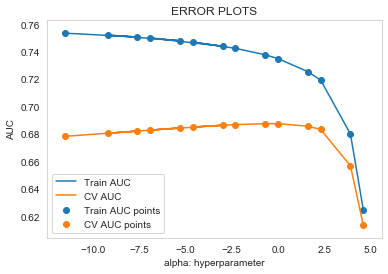

In [62]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
log_alpha=[]
#alpha value taken from course case study 
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
for i in tqdm(alpha):
    print("for alpha =", i)
    naive_bayes = MultinomialNB(alpha=i, class_prior = [0.5, 0.5])
    naive_bayes.fit(X_tr, y_train)

    y_train_pred = batch_predict(naive_bayes, X_tr)    
    y_cv_pred = batch_predict(naive_bayes, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

for j in tqdm(alpha):
    k=math.log(j)
    log_alpha.append(k)

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

# Gridsearch

In [63]:
#https://scikit-learn.org/stable/modules/grid_search.html
#Gridsearchcv 
from sklearn.model_selection import GridSearchCV
naive_bayes = MultinomialNB(class_prior=[0.5,0.5])
#alpha value taken from course case study problem
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = GridSearchCV(naive_bayes, parameters, cv= 10, scoring='roc_auc',return_train_score=True,verbose=2)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...................................... alpha=1e-05, total=   0.4s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.2s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] .

[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .

[CV] ......................................... alpha=10, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ......................................... alpha=10, total=   0.1s
[CV] alpha=50 ........................................................
[CV] ......................................... alpha=50, total=   0.1s
[CV] alpha=50 ........................................................
[CV] ......................................... alpha=50, total=   0.1s
[CV] alpha=50 ........................................................
[CV] ......................................... alpha=50, total=   0.1s
[CV] alpha=50 ........................................................
[CV] ......................................... alpha=50, total=   0.1s
[CV] alpha=50 ........................................................
[CV] ......................................... alpha=50, total=   0.1s
[CV] alpha=50 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   19.5s finished


100%|██████████| 14/14 [00:00<00:00, 5472.53it/s]


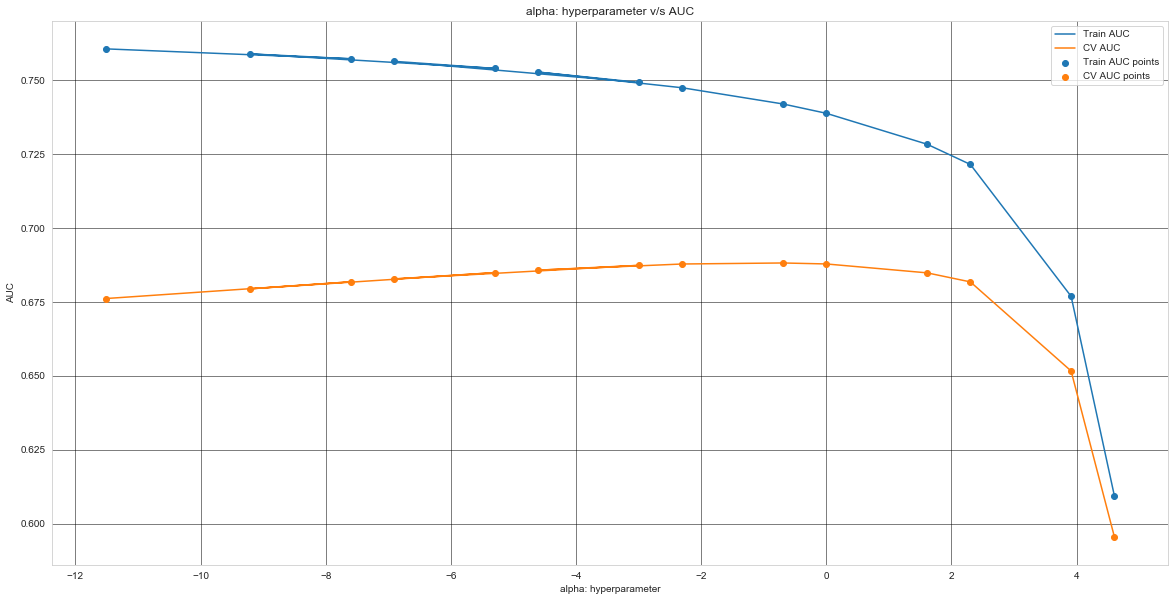

In [65]:
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for j in tqdm(alpha):
    k = math.log(j)
    log_alpha.append(k)

plt.figure(figsize=(20,10))

plt.plot(log_alpha, train_auc, label='Train AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')



plt.plot(log_alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [66]:
#Output of GridSearchCV
print('Best score: ',clf.best_score_)
print('Bset alpha value : ',clf.best_params_)


Best score:  0.688214401808872
Bset alpha value :  {'alpha': 0.5}


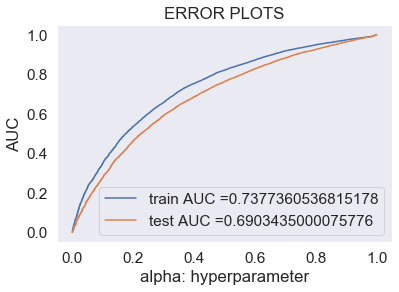

In [82]:
best_alpha=0.5
from sklearn.metrics import roc_curve, auc


naive_bayes_bow = MultinomialNB(alpha=0.5,class_prior = [0.5, 0.5])
naive_bayes_bow.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(naive_bayes_bow, X_tr)    
y_test_pred = batch_predict(naive_bayes_bow, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [83]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
print("="*100)

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4641284479045425 for threshold 0.339
Train confusion matrix
[[ 4869  2557]
 [12157 29458]]
Test confusion matrix
[[ 3214  2245]
 [ 9361 21232]]


# calculate confusion matrix for train data

Train data confusion matrix


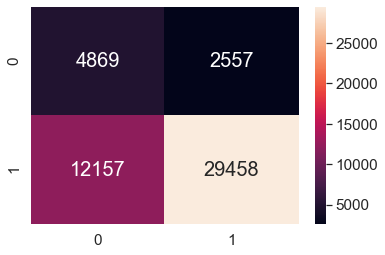

In [84]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix/35572520#35572520
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

print("Train data confusion matrix")

confusion_matrix_train_data = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_train_data, annot=True,annot_kws={"size": 20}, fmt='g')


# calculate confusion matrix for test data

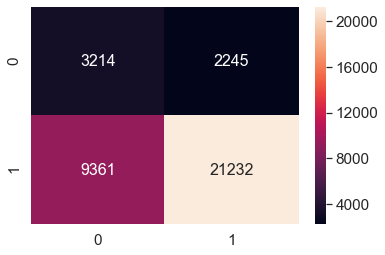

In [85]:
confusion_matrix_test_data = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_test_data, annot=True,annot_kws={"size": 16}, fmt='g')

# top20 feature Bow of project_title and essay

In [86]:
#https://www.geeksforgeeks.org/python-ways-to-concatenate-two-lists/
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
bow_features=[]
for f1 in vectorizer_essay_bow.get_feature_names():
    bow_features.append(f1)
    
for f2 in vectorizer_project_title_bow.get_feature_names():
    bow_features.append(f2)

for f3 in vectorizer_school_state.get_feature_names():
    bow_features.append(f3)
    
for f4 in vectorizer_teacher_prefix.get_feature_names():
    bow_features.append(f4)
    
for f5 in  vectorizer_project_grade_category.get_feature_names():
    bow_features.append(f5)

for f6 in vectorizer_project_subject_category.get_feature_names():
    bow_features.append(f6)
    
for f7 in vectorizer_project_subject_subcategories.get_feature_names():
    bow_features.append(f7)

bow_features.append("price")

bow_features.append("title_word_count")
bow_features.append("essay_word_count")
bow_features.append("teacher_number_of_previously_posted_projects")

In [87]:
len(bow_features)

8901

In [93]:
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
#top20 positive feature and negative fature

print('Top 20 features from positive class:')
neg_class_prob_sorted = naive_bayes_bow.feature_log_prob_[0, :].argsort()   #class 0
pos_class_prob_sorted = naive_bayes_bow.feature_log_prob_[1, :].argsort()   #c
print(np.take(bow_features, neg_class_prob_sorted[-20:]))
print('-'*50)
print(np.take(bow_features, pos_class_prob_sorted[-20:]))

Top 20 features from positive class:
['use' 'skills' 'materials' 'able' 'reading' 'day' 'love'
 'teacher_number_of_previously_posted_projects' 'come' 'work' 'need'
 'many' 'nannan' 'help' 'learn' 'not' 'classroom' 'learning' 'school'
 'students']
--------------------------------------------------
['would' 'class' 'come' 'able' 'day' 'love'
 'teacher_number_of_previously_posted_projects' 'use' 'reading' 'need'
 'work' 'nannan' 'many' 'help' 'learn' 'not' 'classroom' 'learning'
 'school' 'students']


# calculate tfidf for feature project_title and essay

In [94]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_essay_tfidf = TfidfVectorizer()
vectorizer_essay_tfidf.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_essay_tfidf.transform(X_train['preprocessed_essays'].values)
X_cv_essay_tfidf = vectorizer_essay_tfidf.transform(X_cv['preprocessed_essays'].values)
X_test_essay_tfidf =vectorizer_essay_tfidf.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

print("="*100)

(49041, 13) (49041,)
(24155, 13) (24155,)
(36052, 13) (36052,)
After vectorizations
(49041, 41126) (49041,)
(24155, 41126) (24155,)
(36052, 41126) (36052,)


In [95]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

vectorizer_project_title_tfidf = TfidfVectorizer()
vectorizer_project_title_tfidf.fit(X_train['preprocessed_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_tfidf = vectorizer_project_title_tfidf.transform(X_train['preprocessed_titles'].values)
X_cv_project_title_tfidf = vectorizer_project_title_tfidf.transform(X_cv['preprocessed_titles'].values)
X_test_project_title_tfidf =vectorizer_project_title_tfidf.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(X_train_project_title_tfidf.shape, y_train.shape)
print(X_cv_project_title_tfidf.shape, y_cv.shape)
print(X_test_project_title_tfidf.shape, y_test.shape)

print("="*100)

(49041, 13) (49041,)
(24155, 13) (24155,)
(36052, 13) (36052,)
After vectorizations
(49041, 11537) (49041,)
(24155, 11537) (24155,)
(36052, 11537) (36052,)


# Concatinating all the features

In [96]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_2 = hstack((X_train_essay_tfidf,X_train_project_title_tfidf,X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_subject_ohe,X_train_sub_subject_ohe,X_train_price_norm,X_train_title_word_count_norm,X_train_essay_word_count_norm,X_train_project_submit_count_norm)).tocsr()
X_cr_2 = hstack((X_cv_essay_tfidf,X_cv_project_title_tfidf,X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_subject_ohe,X_cv_sub_subject_ohe,X_cv_price_norm,X_cv_title_word_count_norm,X_cv_essay_word_count_norm,X_cv_project_submit_count_norm)).tocsr()
X_te_2 = hstack((X_test_essay_tfidf,X_test_project_title_tfidf,X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_subject_ohe,X_test_sub_subject_ohe,X_test_price_norm,X_test_title_word_count_norm,X_test_essay_word_count_norm,X_test_project_submit_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr_2.shape, y_train.shape)
print(X_cr_2.shape, y_cv.shape)
print(X_te_2.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 53154) (49041,)
(24155, 53154) (24155,)
(36052, 53154) (36052,)


In [97]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

  0%|          | 0/14 [00:00<?, ?it/s]

for alpha = 1e-05


  7%|▋         | 1/14 [00:00<00:05,  2.28it/s]

for alpha = 0.0005


 14%|█▍        | 2/14 [00:00<00:04,  2.40it/s]

for alpha = 0.0001


 21%|██▏       | 3/14 [00:01<00:04,  2.34it/s]

for alpha = 0.005


 29%|██▊       | 4/14 [00:01<00:04,  2.50it/s]

for alpha = 0.001


 36%|███▌      | 5/14 [00:01<00:03,  2.60it/s]

for alpha = 0.05


 43%|████▎     | 6/14 [00:02<00:02,  2.72it/s]

for alpha = 0.01


 50%|█████     | 7/14 [00:02<00:02,  2.82it/s]

for alpha = 0.1


 57%|█████▋    | 8/14 [00:02<00:02,  2.76it/s]

for alpha = 0.5


 64%|██████▍   | 9/14 [00:03<00:01,  2.85it/s]

for alpha = 1


 71%|███████▏  | 10/14 [00:03<00:01,  2.92it/s]

for alpha = 5


 79%|███████▊  | 11/14 [00:03<00:01,  2.93it/s]

for alpha = 10


 86%|████████▌ | 12/14 [00:04<00:00,  2.87it/s]

for alpha = 50


 93%|█████████▎| 13/14 [00:04<00:00,  2.91it/s]

for alpha = 100


100%|██████████| 14/14 [00:00<00:00, 13270.11it/s]


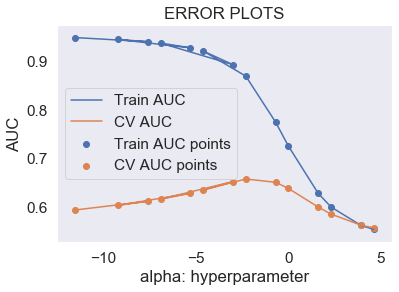

In [98]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
log_alpha=[]
#alpha value taken from course case study 
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
for i in tqdm(alpha):
    print("for alpha =", i)
    naive_bayes_tfidf = MultinomialNB(alpha=i,class_prior = [0.5, 0.5])
    naive_bayes_tfidf.fit(X_tr_2, y_train)

    y_train_pred = batch_predict( naive_bayes_tfidf, X_tr_2)    
    y_cv_pred = batch_predict( naive_bayes_tfidf, X_cr_2)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

for j in tqdm(alpha):
    k=math.log(j)
    log_alpha.append(k)

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

# Gridsearch for tfidf vector


Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.2s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] .

[CV] ....................................... alpha=0.05, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .

[CV] ......................................... alpha=10, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ......................................... alpha=10, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ......................................... alpha=10, total=   0.1s
[CV] alpha=50 ........................................................
[CV] ......................................... alpha=50, total=   0.1s
[CV] alpha=50 ........................................................
[CV] ......................................... alpha=50, total=   0.1s
[CV] alpha=50 ........................................................
[CV] ......................................... alpha=50, total=   0.1s
[CV] alpha=50 ........................................................
[CV] ......................................... alpha=50, total=   0.1s
[CV] alpha=50 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   19.4s finished


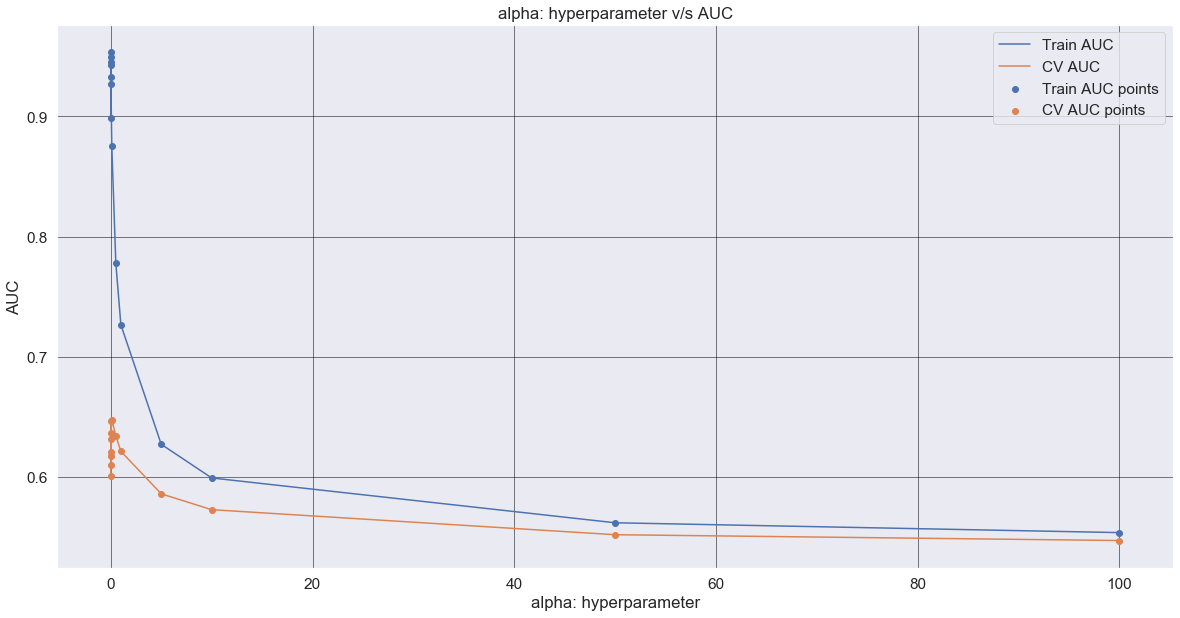

In [99]:
#https://scikit-learn.org/stable/modules/grid_search.html
#Gridsearchcv 
from sklearn.model_selection import GridSearchCV
naive_bayes = MultinomialNB(class_prior=[0.5,0.5])
#alpha value taken from course case study problem
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = GridSearchCV(naive_bayes, parameters, cv= 10, scoring='roc_auc',return_train_score=True,verbose=2)

clf.fit(X_tr_2, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]


plt.figure(figsize=(20,10))

plt.plot(alpha, train_auc, label='Train AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')



plt.plot(alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [100]:
#Output of GridSearchCV
print('Best score: ',clf.best_score_)
print('Best alpha value : ',clf.best_params_)


Best score:  0.6474980865573342
Best alpha value :  {'alpha': 0.1}


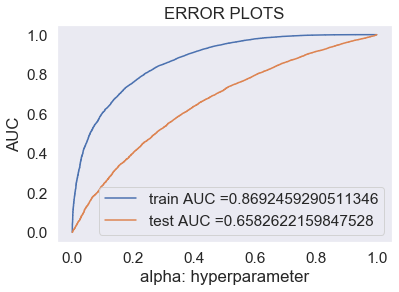

In [101]:
best_alpha=0.1
from sklearn.metrics import roc_curve, auc


naive_bayes_tfidf = MultinomialNB(alpha=0.1,class_prior = [0.5, 0.5] )
naive_bayes_tfidf.fit(X_tr_2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(naive_bayes_tfidf, X_tr_2)    
y_test_pred = batch_predict(naive_bayes_tfidf, X_te_2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [102]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6114695068639759 for threshold 0.525
Train confusion matrix
[[ 5650  1776]
 [ 8170 33445]]
Test confusion matrix
[[ 2517  2942]
 [ 7578 23015]]


# calculate confusion matrix on set2 train data 

Train data confusion matrix


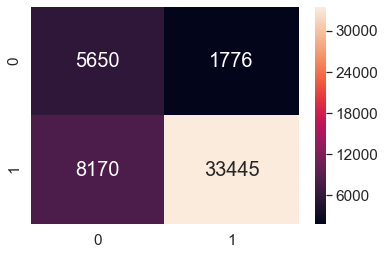

In [104]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix/35572520#35572520
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

print("Train data confusion matrix")

confusion_matrix_train_data_set2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_train_data_set2, annot=True,annot_kws={"size": 20}, fmt='g')


# calculate confusion matrix on set2 test data

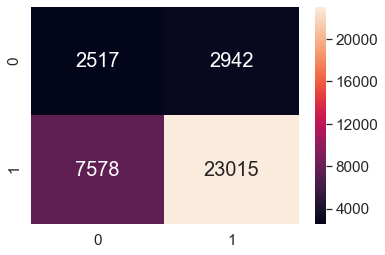

In [105]:
confusion_matrix_test_data_set2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_test_data_set2, annot=True,annot_kws={"size": 20}, fmt='g')


In [107]:
#https://www.geeksforgeeks.org/python-ways-to-concatenate-two-lists/
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_features=[]
for f1 in vectorizer_essay_tfidf.get_feature_names():
    tfidf_features.append(f1)
    
for f2 in vectorizer_project_title_tfidf.get_feature_names():
    tfidf_features.append(f2)

for f3 in vectorizer_school_state.get_feature_names():
    tfidf_features.append(f3)
    
for f4 in vectorizer_teacher_prefix.get_feature_names():
    tfidf_features.append(f4)
    
for f5 in  vectorizer_project_grade_category.get_feature_names():
    tfidf_features.append(f5)

for f6 in vectorizer_project_subject_category.get_feature_names():
    tfidf_features.append(f6)
    
for f7 in vectorizer_project_subject_subcategories.get_feature_names():
    tfidf_features.append(f7)

tfidf_features.append("price")
tfidf_features.append("quantity")
tfidf_features.append("title_word_count")
tfidf_features.append("essay_word_count")
tfidf_features.append("teacher_number_of_previously_posted_projects")

In [108]:
len(tfidf_features)

53155

In [110]:
#find top20 feature using tfidf 
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

neg_class_prob_sorted = naive_bayes_tfidf.feature_log_prob_[0, :].argsort()   #class 0
pos_class_prob_sorted = naive_bayes_tfidf.feature_log_prob_[1, :].argsort()   #class1
print("Top 20 Negative features from set2")
print(np.take(tfidf_features, neg_class_prob_sorted[:20]))
print('-'*100)
print("Top 20 Positive features from set2")
print(np.take(tfidf_features, pos_class_prob_sorted[:20]))

Top 20 Negative features from set2
['litany' 'overdoses' 'overdeck' 'overcommitted' 'islanders' 'vigorous'
 'overcast' 'overbearing' 'viii' 'overaged' 'overactivity' 'overactive'
 'overachieving' 'overachievers' 'overachiever' 'overabundance' 'ovens'
 'islands' 'ovary' 'oval']
----------------------------------------------------------------------------------------------------
Top 20 Positive features from set2
['therapeutically' 'eyedroppers' 'eyesore' 'pics' 'blackfeet' 'wasco'
 'picoult' 'jordanian' 'linus' 'jope' 'miguelito' 'faceing' 'facelift'
 'wast' 'wasteland' 'snacs' 'eyebrow' 'snips' 'wasatch' 'extruder']


In [111]:
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Alpha:Hyper Parameter", "Test-AUC"]

x.add_row(["BagOfWords", "MultinomialNaive Bayes", 0.5, 0.69])
x.add_row(["TFIDF", "MultinomialNaive Bayes", 0.1, 0.64])

print(x)

+------------+------------------------+-----------------------+----------+
| Vectorizer |         Model          | Alpha:Hyper Parameter | Test-AUC |
+------------+------------------------+-----------------------+----------+
| BagOfWords | MultinomialNaive Bayes |          0.5          |   0.69   |
|   TFIDF    | MultinomialNaive Bayes |          0.1          |   0.64   |
+------------+------------------------+-----------------------+----------+


Summary : After Unvariate amalyisis teachener number of project previously submitted ,we find that it will affect on project approved or not.so we include that feature in model.I used Gridsearch and compute best alpha paramter for both Bag of words and tfidf and got test accuracy score 0.68 and 0.64.Also find set 1 and set 2 top 20 features.